# 01 - Data Preparation and EDA

### 
The goal of this notebook is to prepare the master dataset from which training data could be generated. The original dataset resides in the folder `OriginalDataset` which is a relational db represented in flat files of the following format:

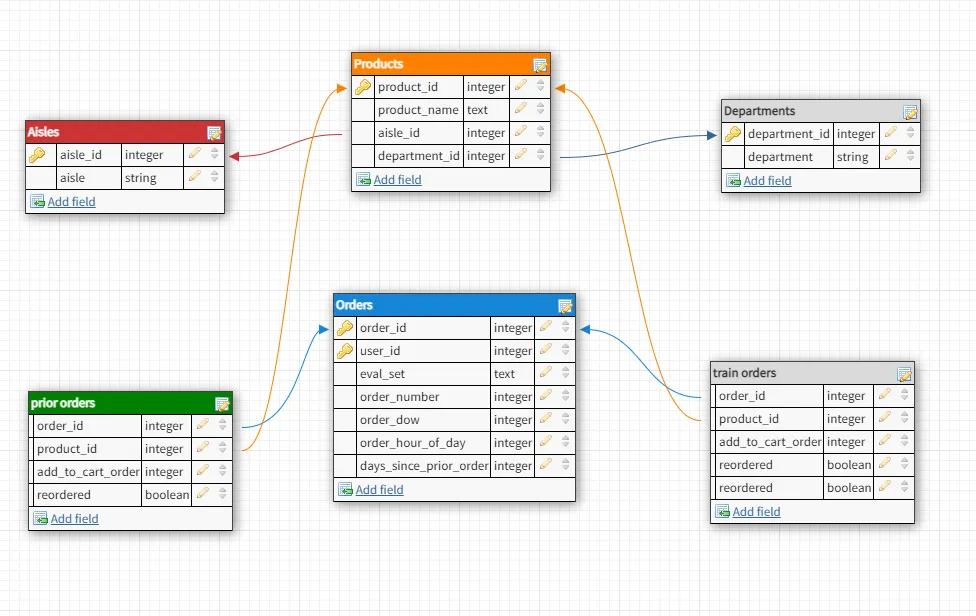

The goal is to use all the dataset in `orders.csv` file with the eval_set as `prior` to generate the master dataset of all the prior orders. This dataset would be used to generate the features that are required to predict the re-order rate given a user and a product.

Then perform EDA on this dataset to understand it's nuances around Order patterns, product analytics, user behavior and customer segmentation

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc 

warnings.filterwarnings("ignore")
sns.set_theme("paper")

### Data Loading

In [2]:
def createDataset():
    '''
    Method to check if the TrainingDataset has already been curated and saved
    and generate if not. This will result in two dataframes 
    df -> Which is a huge transactional data of all orders in chronological order by all users along with order information
    meta -> Which is a simple entity table holding the meta information of all products

    products -- departments -- aisle -- > Meta
    prior_orders -- orders -- > df (sorted by user, order, item_order)
    '''

    ## Load the original dataset
    products = pd.read_csv(f"../OriginalDataset/products.csv")
    departments = pd.read_csv(f"../OriginalDataset/departments.csv")
    aisles = pd.read_csv(f"../OriginalDataset/aisles.csv")

    orders = pd.read_csv("../OriginalDataset/orders.csv")
    prior_orders = pd.read_csv("../OriginalDataset/order_products__prior.csv")
    
    data = products.merge(departments, left_on="department_id", right_on="department_id", how="left")
    data = data.merge(aisles, left_on="aisle_id", right_on="aisle_id", how="left")
    data = data[["product_id", "product_name", "department", "aisle"]]

    df = prior_orders.merge(orders, left_on="order_id", right_on="order_id")
    df = df.sort_values(by=["user_id", "order_number", "add_to_cart_order"], ascending=True).reset_index(drop=True)
    df = df[["order_id", "user_id", "order_number", "order_dow", "order_hour_of_day", "days_since_prior_order", "product_id", "add_to_cart_order", "reordered"]]
    df = df.rename(columns={"add_to_cart_order": "cart_order"})

    return df, data

In [3]:
df, meta = createDataset()
df.to_csv("../Dataset/TrainingDataset.csv")
meta.to_csv("../Dataset/Metadata.csv")

In [4]:
gc.collect()

0

### EDA

In [2]:
df = pd.read_csv("../Dataset/TrainingDataset.csv", index_col=0)
meta_data = pd.read_csv("../Dataset/Metadata.csv", index_col=0)

In [3]:
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,cart_order,reordered
0,2539329,1,1,2,8,NaN,196,1,0
1,2539329,1,1,2,8,NaN,14084,2,0
2,2539329,1,1,2,8,NaN,12427,3,0
3,2539329,1,1,2,8,NaN,26088,4,0
4,2539329,1,1,2,8,NaN,26405,5,0


In [4]:
meta_data.head()

,product_id,product_name,department,aisle
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes
1,2,All-Seasons Salt,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals
4,5,Green Chile Anytime Sauce,pantry,marinades meat preparation


#### Order Patterns

In [9]:
## 1. When are the orders placed ? Day and hour
##### Higher orders during the weekend and it tapers down throughout the day and peaks as weekend approached
##### 10AM - 4PM is when the activity peaks up and slowly dies around 12 AM. And then starts back at 6AM

## 2. How frequently are the order placed ? 
##### Reordering happens either on weekly/bi-weekly/monthly levels (Grocery Shopping - Planned)
##### Within a week, there are re-ordering happening. Analyze why large number of re-orders are done on the same day
##### Looks like same day re-orders are happening at random

## 3. How often items are re-ordered ? 
##### Overall 37% of items are being re-ordered. Which is good for the store. This means the inventory could be 
##### piled up without worry for demand.

## 4. Does re-ordering have a temporal effect ? Visualize probability of reordering a heatmap
##### People tend to re-order a lot during the morning hours on the weekends again. This should probably indicate
##### that routine buyers are likely to stick to their order. Late night orders have lower probability (Cravings??)

In [ ]:
path = "../Plots/OrderPatterns"
if os.path.exists(path) == False:
    os.makedirs(path)

order_dow_counts = df['order_dow'].value_counts().sort_index()
reorder_dow_counts = df[df.reordered == 1]['order_dow'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=order_dow_counts.index, y=order_dow_counts.values, color="blue", label="Order")
sns.barplot(x=reorder_dow_counts.index, y=reorder_dow_counts.values, color="red", label="Reorder")
plt.title('Distribution of Orders and Reorders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.savefig(f"{path}/Distribution of Orders by Day of the Week.png")
plt.close()

order_hour_counts = df['order_hour_of_day'].value_counts().sort_index().reset_index()
order_hour_counts["diff"] = order_hour_counts["count"].diff(1)/1000000

reorder_hour_counts = df[df.reordered == 1]['order_hour_of_day'].value_counts().sort_index().reset_index()
reorder_hour_counts["diff"] = reorder_hour_counts["count"].diff(1)/1000000

fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(x=order_hour_counts.order_hour_of_day, y=order_hour_counts["count"], ax=ax, color="blue", label="Orders")
sns.barplot(x=reorder_hour_counts.order_hour_of_day, y=reorder_hour_counts["count"], ax=ax, color="red", label="Reorders")

ax2 = ax.twinx()
sns.lineplot(x=order_hour_counts.order_hour_of_day, y=order_hour_counts["diff"], ax=ax2, color="lightblue", linestyle="--")
sns.lineplot(x=reorder_hour_counts.order_hour_of_day, y=reorder_hour_counts["diff"], ax=ax2, color="pink", linestyle="--")
plt.title('Distribution of Orders by Hour of the Day')
plt.xlabel('Hour of the Day')
ax.set_ylabel('Number of Orders')
ax2.set_ylabel('Diff in orders (1e6)')
plt.savefig(f"{path}/Distribution of Orders by Hour of the Day.png")
plt.close()

plt.figure(figsize=(10,5))
order_frequency = df['days_since_prior_order'].fillna(0).astype(int).value_counts().sort_index()
sns.barplot(x=order_frequency.index, y=order_frequency.values)
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Frequency')
plt.savefig(f"{path}/Distribution of Days Since Prior Order.png")
plt.close()

reordered_frequency = df[~df.days_since_prior_order.isna()]['reordered'].value_counts(normalize=True)
plt.figure(figsize=(4,4))
reordered_frequency.plot(kind='pie', autopct='%1.1f%%', labels=['Not Reordered', 'Reordered'])
plt.title('Reordered Items Percentage')
plt.ylabel('')
plt.savefig(f"{path}/Reordered Items Percentage.png")
plt.close()

reorder_heatmap_data = df.groupby(['order_dow', 'order_hour_of_day'])['reordered'].mean().reset_index()
plt.figure(figsize=(10,5))
reorder_heatmap = reorder_heatmap_data.pivot_table(index='order_dow', columns='order_hour_of_day', values='reordered')
sns.heatmap(reorder_heatmap, cmap="YlGnBu", fmt=".2f")
plt.title('Probability of Reordering by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.savefig(f"{path}/Probability of Reordering - Heatmap.png")
plt.close()

In [ ]:
### What's with same day reordering ???
reordered_df = df[df['reordered'] == 1]

reordered_df = reordered_df.sort_values(by=['user_id', 'order_number', 'product_id'])
reordered_df['hour_difference'] = reordered_df.groupby(['user_id', 'product_id'])['order_hour_of_day'].diff()

same_day_reorders = reordered_df[((reordered_df.days_since_prior_order == 0) & (reordered_df.hour_difference > 0))][["product_id", "hour_difference"]]

same_day_reorders["product_name"] = same_day_reorders["product_id"].apply(lambda x: meta_data.loc[x-1, "product_name"])
same_day_reorders["department"] = same_day_reorders["product_id"].apply(lambda x: meta_data.loc[x-1, "department"])
same_day_reorders["aisle"] = same_day_reorders["product_id"].apply(lambda x: meta_data.loc[x-1, "aisle"])

product_reorder_data = same_day_reorders.groupby(["department", "aisle"]).agg(
    avg_reorder_time = ("hour_difference", "mean"),
    total_reorders = ("product_name", "count")
).reset_index()

product_reorder_data = product_reorder_data.sort_values(by=["total_reorders"], ascending=False)
product_reorder_data[product_reorder_data.total_reorders > 1000]

,department,aisle,avg_reorder_time,total_reorders
118,produce,fresh fruits,4.513147,16315
120,produce,fresh vegetables,4.783808,12179
122,produce,packaged vegetables fruits,4.746621,6437
42,dairy eggs,yogurt,4.358773,5739
21,beverages,water seltzer sparkling water,4.308038,4902
36,dairy eggs,milk,4.475259,4143
40,dairy eggs,soy lactosefree,4.435653,3046
38,dairy eggs,packaged cheese,4.447397,2747
124,snacks,chips pretzels,4.313781,2489
18,beverages,refrigerated,4.534751,2446


#### Product Analytics

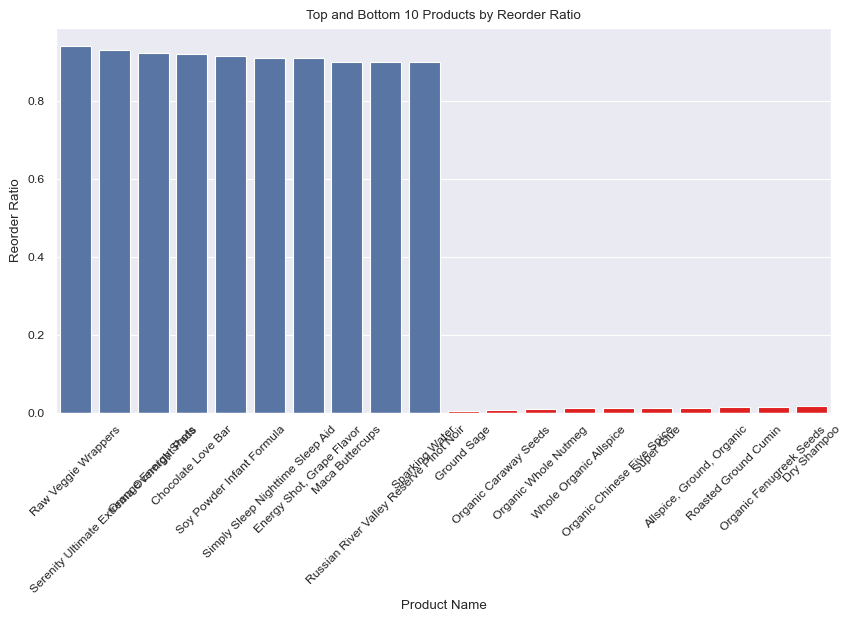

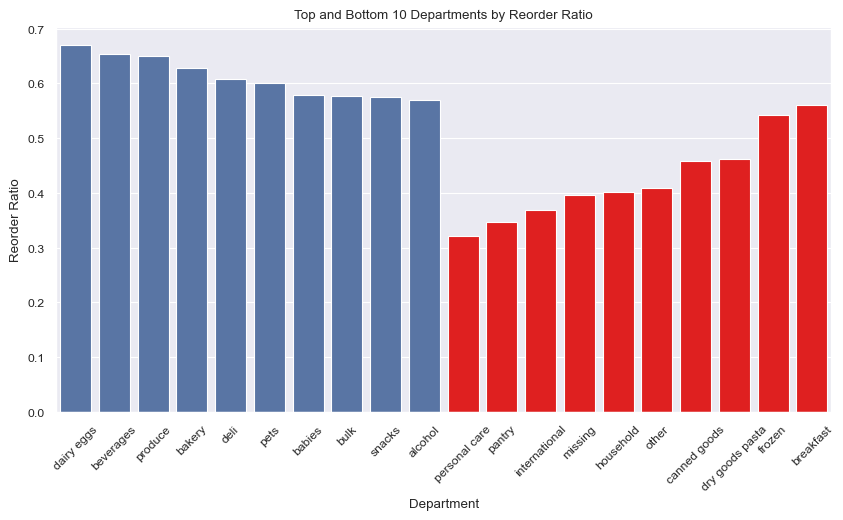

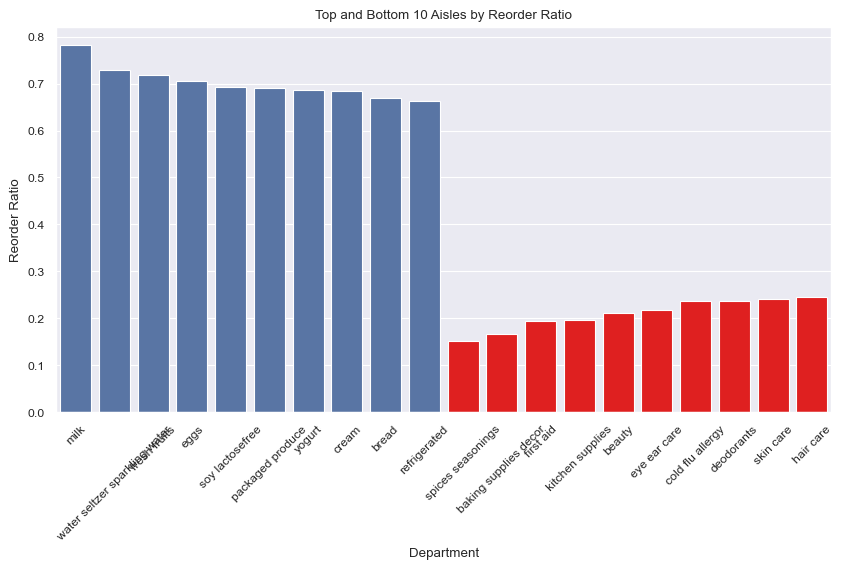

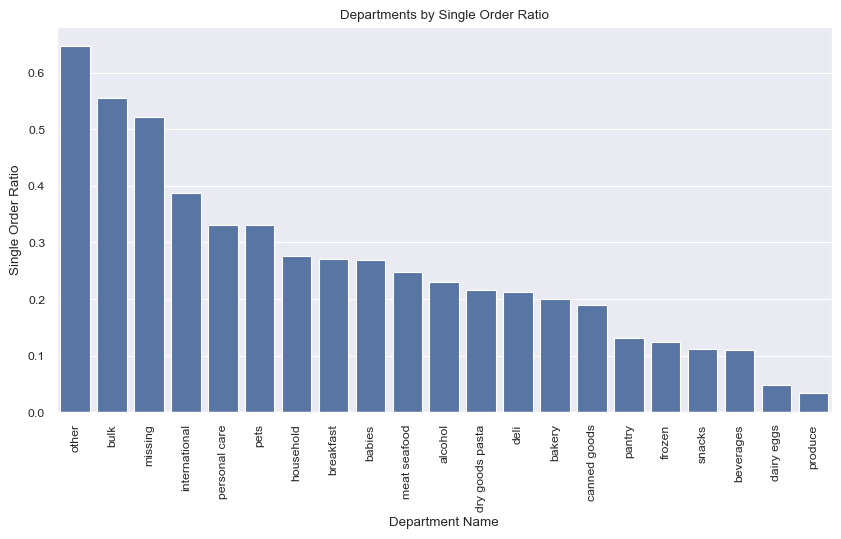

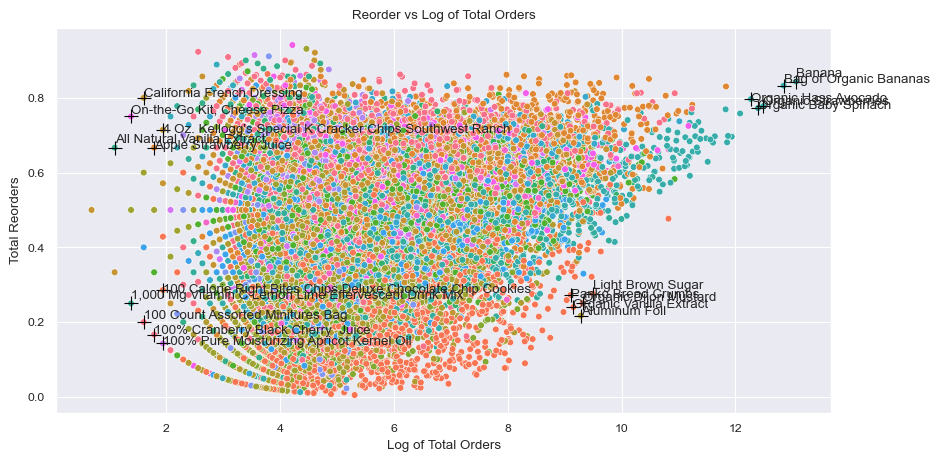

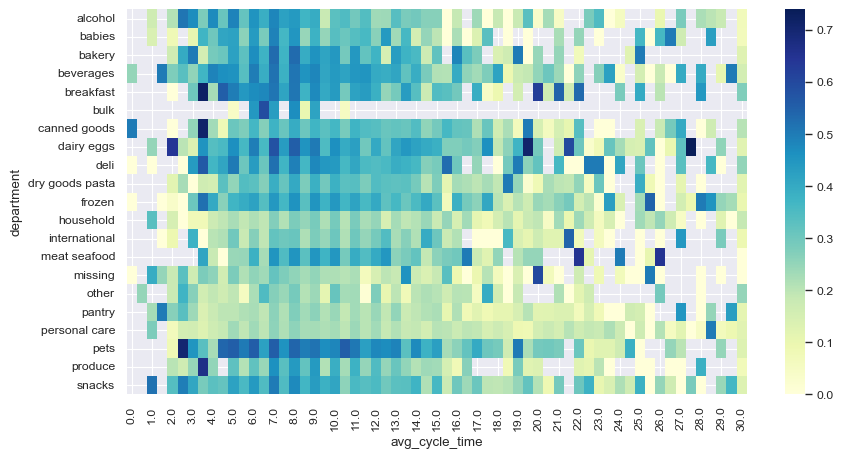

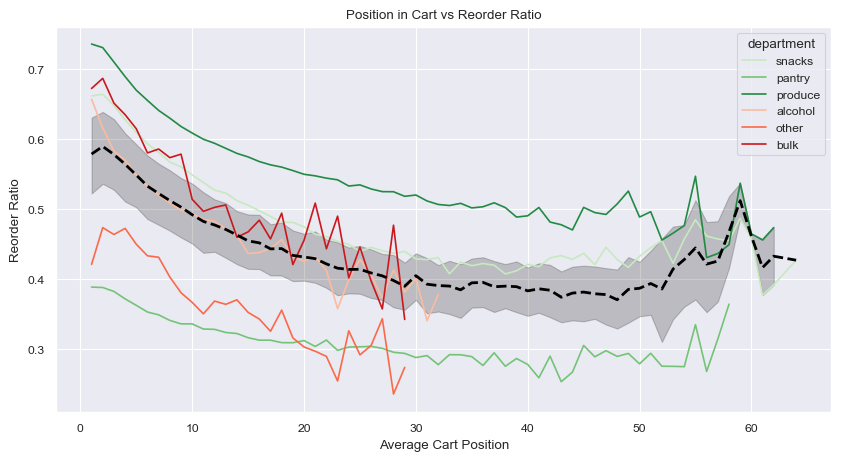

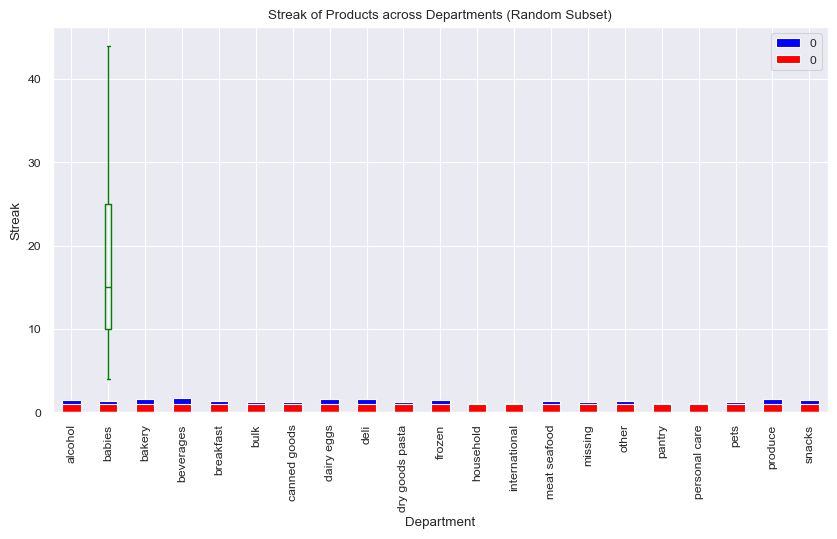

In [6]:
# Merge with meta_data for product, department, and aisle names
if "department" not in df.columns:
    df = df.merge(meta_data, on='product_id', how='left')

# 1. Product/Department/Aisle Reorder Ratio
reorder_ratio = df.groupby('product_name')['reordered'].mean().reset_index()
top_reorder_ratio = reorder_ratio.nlargest(10, 'reordered')
bottom_reorder_ratio = reorder_ratio[reorder_ratio.reordered != 0].nsmallest(10, 'reordered')

plt.figure(figsize=(10,5))
sns.barplot(data=top_reorder_ratio, x='product_name', y='reordered')
sns.barplot(data=bottom_reorder_ratio, x='product_name', y='reordered',color="red")
plt.xticks(rotation=45)
plt.title('Top and Bottom 10 Products by Reorder Ratio')
plt.xlabel('Product Name')
plt.ylabel('Reorder Ratio')
plt.show()

reorder_ratio = df.groupby('department')['reordered'].mean().reset_index()
top_reorder_ratio = reorder_ratio.nlargest(10, 'reordered')
bottom_reorder_ratio = reorder_ratio[reorder_ratio.reordered != 0].nsmallest(10, 'reordered')

plt.figure(figsize=(10,5))
sns.barplot(data=top_reorder_ratio, x='department', y='reordered')
sns.barplot(data=bottom_reorder_ratio, x='department', y='reordered',color="red")
plt.xticks(rotation=45)
plt.title('Top and Bottom 10 Departments by Reorder Ratio')
plt.xlabel('Department')
plt.ylabel('Reorder Ratio')
plt.show()

reorder_ratio = df.groupby('aisle')['reordered'].mean().reset_index()
top_reorder_ratio = reorder_ratio.nlargest(10, 'reordered')
bottom_reorder_ratio = reorder_ratio[reorder_ratio.reordered != 0].nsmallest(10, 'reordered')

plt.figure(figsize=(10,5))
sns.barplot(data=top_reorder_ratio, x='aisle', y='reordered')
sns.barplot(data=bottom_reorder_ratio, x='aisle', y='reordered',color="red")
plt.xticks(rotation=45)
plt.title('Top and Bottom 10 Aisles by Reorder Ratio')
plt.xlabel('Department')
plt.ylabel('Reorder Ratio')
plt.show()

# 2. One shot ratio of products across departments
user_product_order_count = df.groupby(['user_id', 'department']).size().reset_index(name='count')
single_order_ratio = user_product_order_count[user_product_order_count['count'] == 1].groupby('department').size() / user_product_order_count.groupby('department').size()
single_order_ratio = single_order_ratio.reset_index(name='single_order_ratio').sort_values(by="single_order_ratio", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=single_order_ratio, x='department', y='single_order_ratio')
plt.xticks(rotation=90)
plt.title('Departments by Single Order Ratio')
plt.xlabel('Department Name')
plt.ylabel('Single Order Ratio')
plt.show()

# 3. Reorder vs Log of Total Orders
reorder_vs_log = df.groupby(["product_name", "department", "aisle"]).agg(
    reorder_percent = ("reordered", "mean"),
    total_orders = ("user_id", "count")
).reset_index()
reorder_vs_log = reorder_vs_log[reorder_vs_log.reorder_percent > 0]
reorder_vs_log["log_total_orders"] = reorder_vs_log["total_orders"].apply(lambda x: np.log(x))


frequent_reorders = reorder_vs_log[((reorder_vs_log.log_total_orders > 10) & (reorder_vs_log.reorder_percent > 0.6))].drop_duplicates(subset=["log_total_orders", "reorder_percent"]).sort_values(by=["total_orders", "reorder_percent"], ascending=[False, False]).iloc[:5,:]
infrequent_reorders = reorder_vs_log[((reorder_vs_log.log_total_orders < 2) & (reorder_vs_log.reorder_percent > 0.6))].drop_duplicates(subset=["log_total_orders", "reorder_percent"]).sort_values(by=["total_orders", "reorder_percent"], ascending=[True, False]).iloc[:5,:]

infrequent_orders = reorder_vs_log[((reorder_vs_log.log_total_orders < 2) & (reorder_vs_log.reorder_percent < 0.3))].drop_duplicates(subset=["log_total_orders", "reorder_percent"]).sort_values(by=["total_orders", "reorder_percent"], ascending=[True, True]).iloc[:5,:]
frequent_few_shots = reorder_vs_log[((reorder_vs_log.log_total_orders > 8) & (reorder_vs_log.reorder_percent < 0.3))].drop_duplicates(subset=["log_total_orders", "reorder_percent"]).sort_values(by=["total_orders", "reorder_percent"], ascending=[False, True]).iloc[:5,:]

plt.figure(figsize=(10,5))
sns.scatterplot(data=reorder_vs_log, x='log_total_orders', y='reorder_percent', hue='department', legend=False)
sns.scatterplot(data=frequent_reorders, x='log_total_orders', y='reorder_percent', legend=False, marker="+", s=100, color="black")
sns.scatterplot(data=infrequent_reorders, x='log_total_orders', y='reorder_percent', legend=False, marker="+", s=100, color="black")
sns.scatterplot(data=infrequent_orders, x='log_total_orders', y='reorder_percent', legend=False, marker="+", s=100, color="black")
sns.scatterplot(data=frequent_few_shots, x='log_total_orders', y='reorder_percent', legend=False, marker="+", s=100, color="black")

for i in range(5):
    xoffset = 0
    yoffset = 0.005*(2.5-i)
    plt.annotate(frequent_reorders['product_name'].iloc[i], 
                 (frequent_reorders['log_total_orders'].iloc[i] + xoffset, frequent_reorders['reorder_percent'].iloc[i] + yoffset))
    
    plt.annotate(infrequent_reorders['product_name'].iloc[i], 
                 (infrequent_reorders['log_total_orders'].iloc[i] + xoffset, infrequent_reorders['reorder_percent'].iloc[i] + yoffset))
    
    plt.annotate(infrequent_orders['product_name'].iloc[i], 
                 (infrequent_orders['log_total_orders'].iloc[i] + xoffset, infrequent_orders['reorder_percent'].iloc[i] + yoffset))
    
    plt.annotate(frequent_few_shots['product_name'].iloc[i], 
                 (frequent_few_shots['log_total_orders'].iloc[i] + xoffset, frequent_few_shots['reorder_percent'].iloc[i] + yoffset))

plt.title('Reorder vs Log of Total Orders')
plt.xlabel('Log of Total Orders')
plt.ylabel('Total Reorders')
plt.show()

# 4. Cycle Time of Reordering
reorder_cycles = df.groupby(["product_name", "department"]).agg(
    reorder_percent = ("reordered", "mean"),
    avg_cycle_time = ("days_since_prior_order", "median")
).reset_index()

plt.figure(figsize=(10,5))
reorder_cycles_heatmap = reorder_cycles.pivot_table(index='department', columns='avg_cycle_time', values='reorder_percent')
sns.heatmap(reorder_cycles_heatmap, cmap="YlGnBu", fmt=".2f")

# 6. Position in Cart for This Order vs Reorder Ratio
avg_cart_position = df.groupby(['department', 'cart_order']).agg(reorder_ratio = ("reordered", "mean"), num_orders = ("order_id", "count")).reset_index()
avg_cart_position = avg_cart_position[avg_cart_position.num_orders > 100]
avg_cart_position = avg_cart_position.sort_values(by="cart_order", ascending=True).reset_index(drop=True)


top_dept = avg_cart_position.department.value_counts().index[:3]
bottom_dept = avg_cart_position.department.value_counts().index[-3:]
plt.figure(figsize=(10,5))
sns.lineplot(data=avg_cart_position[avg_cart_position.department.isin(top_dept)], x='cart_order', y='reorder_ratio', hue='department', palette=sns.color_palette("Greens", 3))
sns.lineplot(data=avg_cart_position[avg_cart_position.department.isin(bottom_dept)], x='cart_order', y='reorder_ratio', hue='department', palette=sns.color_palette("Reds", 3))
sns.lineplot(data=avg_cart_position, x='cart_order', y='reorder_ratio', linestyle="--", color="black", linewidth=2, legend=False)
plt.title('Position in Cart vs Reorder Ratio')
plt.xlabel('Average Cart Position')
plt.ylabel('Reorder Ratio')
plt.show()

# 7. Maximum Streak of This Order for Any User
def streak(temp):
    temp = pd.crosstab(temp.order_number, temp.product_id)
    for col in temp.columns:
        temp['group'] = (temp[col] == 0).cumsum()
        temp[col] = temp.groupby('group')[col].cumsum()
    temp = temp.drop(["group"], axis=1)
    res = temp.max(axis=0)
    return res

random_user_ids = np.random.default_rng().choice(df.user_id.nunique(), size=1000, replace=False)
df2 = df[df.user_id.isin(random_user_ids)]
df2 = df2.groupby("user_id").apply(streak).reset_index()
df2 = df2.merge(meta_data[["product_id", "department", "aisle"]], left_on="product_id", right_on="product_id")

fig, ax = plt.subplots(1,1,figsize=(10,5))

df3 = df2.groupby("department")[0].max().reset_index()
df3.plot.bar(x="department", y=0, color="green", ax=ax)

df3 = df2.groupby("department")[0].mean().reset_index()
df3.plot.bar(x="department", y=0, color="blue", ax=ax)

df3 = df2.groupby("department")[0].min().reset_index()
df3.plot.bar(x="department", y=0, color="red", ax=ax)

plt.title('Streak of Products across Departments (Random Subset)')
plt.xlabel('Department')
plt.ylabel('Streak')
plt.show()

#### User Behavior

In [101]:
user_pattern = df[df.order_number != 1].groupby("user_id").agg(
    reorder_ratio = ("reordered", "mean"),
    unique_products_ordered = ("product_id", "nunique"),
    total_orders = ("order_number", "count"),
)

user_order_pattern = df[df.order_number != 1].groupby(["user_id", "order_number"]).agg(
    num_of_products = ("product_id", "count"),
    reordered_products = ("reordered", "sum"))

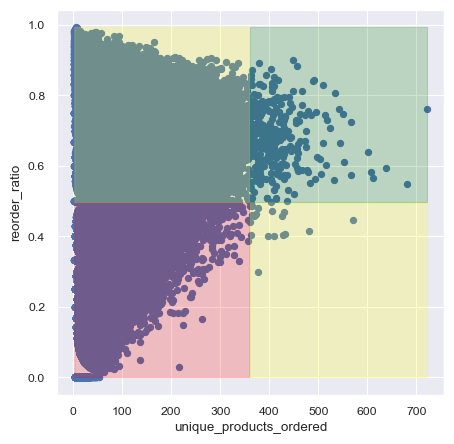

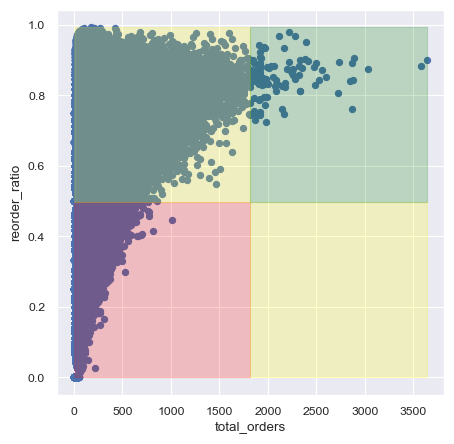

In [94]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
user_pattern.plot.scatter(x="unique_products_ordered", y="reorder_ratio", ax=ax)

x0 = user_pattern.unique_products_ordered.min()
x2 = user_pattern.unique_products_ordered.max()
x1 = (x2-x0)/2

y0 = user_pattern.reorder_ratio.min()
y2 = user_pattern.reorder_ratio.max()
y1 = (y2-y0)/2

X = sorted([item for item in list(user_pattern.unique_products_ordered.values) if item < x1])
ax.fill_between(X, y0, y1, color="red", alpha=0.2)

X = sorted([item for item in list(user_pattern.unique_products_ordered.values) if item > x1])
ax.fill_between(X, y0, y1, color="yellow", alpha=0.2)

X = sorted([item for item in list(user_pattern.unique_products_ordered.values) if item < x1])
ax.fill_between(X, y1, y2, color="yellow", alpha=0.2)

X = sorted([item for item in list(user_pattern.unique_products_ordered.values) if item > x1])
ax.fill_between(X, y1, y2, color="green", alpha=0.2)

fig, ax = plt.subplots(1,1,figsize=(5,5))
user_pattern.plot.scatter(x="total_orders", y="reorder_ratio", ax=ax)

x0 = user_pattern.total_orders.min()
x2 = user_pattern.total_orders.max()
x1 = (x2-x0)/2

y0 = user_pattern.reorder_ratio.min()
y2 = user_pattern.reorder_ratio.max()
y1 = (y2-y0)/2

X = sorted([item for item in list(user_pattern.total_orders.values) if item < x1])
ax.fill_between(X, y0, y1, color="red", alpha=0.2)

X = sorted([item for item in list(user_pattern.total_orders.values) if item > x1])
ax.fill_between(X, y0, y1, color="yellow", alpha=0.2)

X = sorted([item for item in list(user_pattern.total_orders.values) if item < x1])
ax.fill_between(X, y1, y2, color="yellow", alpha=0.2)

X = sorted([item for item in list(user_pattern.total_orders.values) if item > x1])
ax.fill_between(X, y1, y2, color="green", alpha=0.2)

<Axes: xlabel='product_id', ylabel='count'>

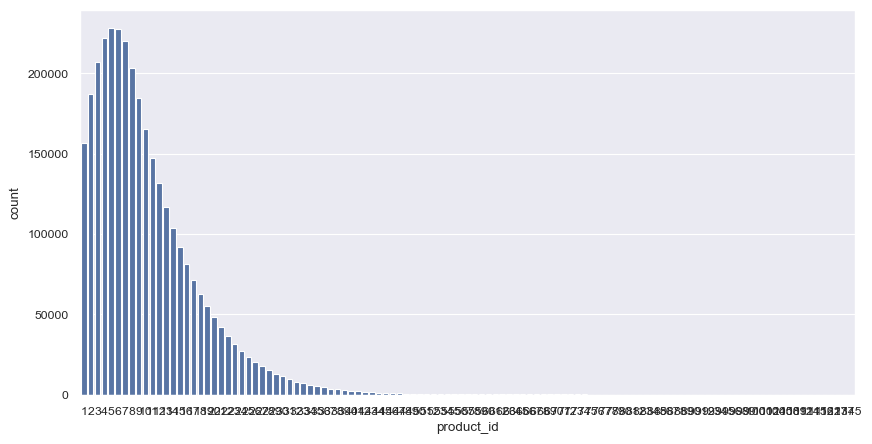

In [95]:
products_in_orders = df.groupby(["user_id", "order_number"])["product_id"].count().reset_index()
fig, ax = plt.subplots(1,1,figsize=(10,5))
products_in_orders = products_in_orders["product_id"].value_counts().reset_index().sort_values(by="product_id")
sns.barplot(data=products_in_orders, x="product_id", y="count")

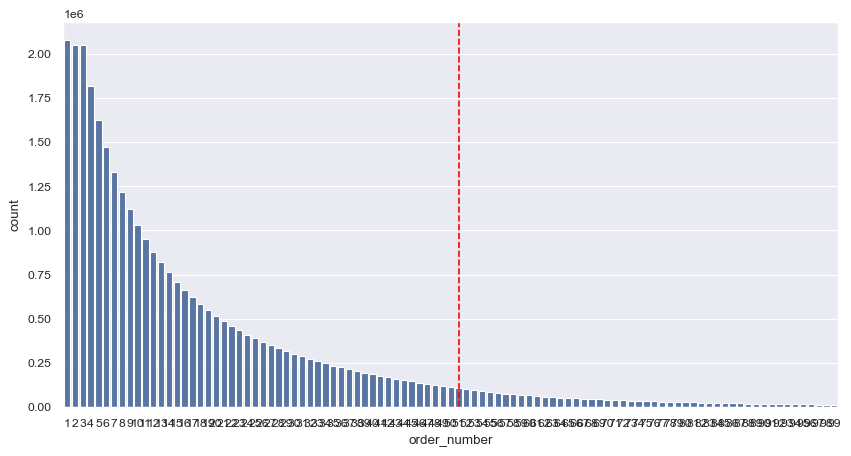

In [97]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
total_orders = df.order_number.value_counts().reset_index()
sns.barplot(data=total_orders, x="order_number", y="count")
ax.axvline(x=50, linestyle="--", color="red")

In [84]:
temp = df[df.order_number >= 4].groupby("user_id")["reordered"].value_counts().reset_index()
temp = temp[temp.reordered == 0]
user_pattern = user_pattern.merge(temp, left_on="user_id", right_on="user_id")

In [87]:
user_pattern["np_w"] = user_pattern["count"]/user_pattern["unique_products_ordered"]

In [108]:
user_order_pattern = user_order_pattern.reset_index()
user_order_pattern["new_product"] = user_order_pattern["num_of_products"] - user_order_pattern["reordered_products"]
user_order_pattern["new_product_ratio"] = user_order_pattern["new_product"]/user_order_pattern["num_of_products"]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97],
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9'),
  Text(8, 0, '10'),
  Text(9, 0, '11'),
  Text(10, 0, '12'),
  Text(11, 0, '13'),
  Text(12, 0, '14'),
  Text(13, 0, '15'),
  Text(14, 0, '16'),
  Text(15, 0, '17'),
  Text(16, 0, '18'),
  Text(17, 0, '19'),
  Text(18, 0, '20'),
  Text(19, 0, '21'),
  Text(20, 0, '22')

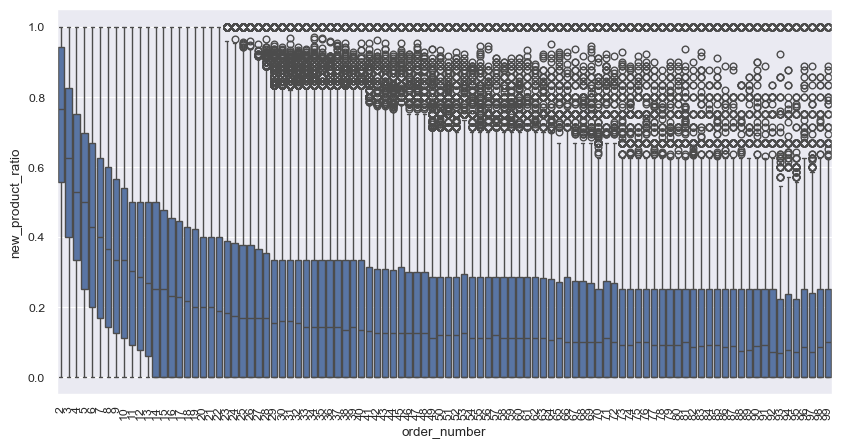

In [113]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(data=user_order_pattern, x="order_number", y="new_product_ratio")
plt.xticks(rotation=90)


In [126]:
diversity = df.groupby(["user_id", "order_number"])["department"].value_counts(normalize=True).reset_index()

KeyboardInterrupt: 

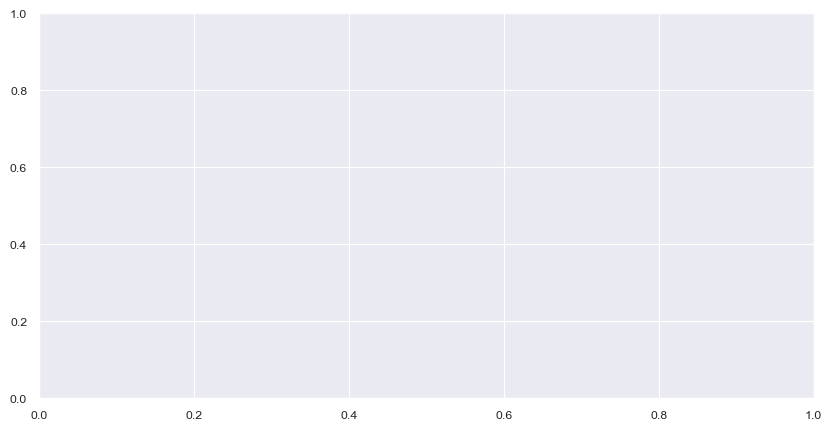

In [130]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
depts = ["produce"]
sns.lineplot(data=diversity[diversity.department.isin(depts)], x="order_number", y="proportion", hue="department")
plt.xticks(rotation=90)

In [123]:
diversity

,order_number,department,proportion
0,1,produce,0.281215
1,1,dairy eggs,0.160259
2,1,snacks,0.087056
3,1,beverages,0.080660
4,1,frozen,0.076188
...,...,...,...
2074,99,alcohol,0.006111
2075,99,missing,0.004905
2076,99,pets,0.001447
2077,99,other,0.001367
